# Adding Human-in-the-Loop Functionality to the Agent: Editing Agent Actions
In this tutorial, we will enhance our chatbot agent by integrating a human-in-the-loop step that allows a human operator to edit the agent's actions before they are executed. This is particularly useful when you want to ensure the agent's decisions align with specific guidelines or to correct any potential errors.

Be sure to have completed the previous tutorials in this module before proceeding, as we will be building on top of the earlier code. For simplicity, we'll only be using the Tavily search tool in this tutorial.

### Imports
We start by importing the necessary libraries:
    

In [66]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from typing import Annotated
from typing_extensions import TypedDict

from dotenv import load_dotenv
_ = load_dotenv()

### Setup and Configuration
We define the model, tools, and the graph structure.

In [95]:
# Defining the model
llm = ChatOpenAI(model="gpt-4o")

# Defining the search tool
tavily_search = TavilySearchResults(max_results=2)

# List of tools for the agent
tools = [tavily_search]

# Binding tools to the LLM
llm_with_tools = llm.bind_tools(tools)

# Defining the StateGraph
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Defining the nodes
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Defining the edges
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")


### Setting up Human-in-the-Loop with Action Editing
We set up checkpointing for the conversation state and compile the graph with interruption before calling any tools. This allows a human operator to inspect and edit the agent's actions (tool calls) before they are executed.

In [96]:
# Setting up checkpointing for conversation state
memory = MemorySaver()

# Compiling the graph with human-in-the-loop interruption
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]  # Interrupt before executing tools
)

### Visualizing the Agent's Workflow
We can visualize the agent's workflow using LangGraph's graph visualization tools. This helps us understand how the agent transitions between nodes and where the interruptions occur.

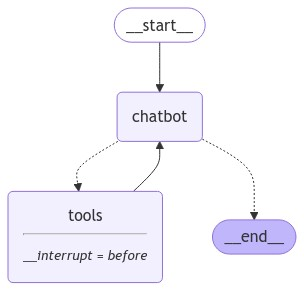

In [97]:
from IPython.display import display, Image

# Visualize the agent's workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies

### Testing the Human-in-the-Loop Functionality
Let's test the agent with a query that requires tool usage.

In [98]:
# User query that triggers tool usage
user_input = "Search the web for the population of singapore"
config = {"configurable": {"thread_id": "1"}}

# Invoking the agent
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Search the web for the population of singapore
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_b4auZ6pDZ969Ruo4WAn1QPoc)
 Call ID: call_b4auZ6pDZ969Ruo4WAn1QPoc
  Args:
    query: current population of Singapore 2023


### Inspecting and Editing the Agent's Actions
At this point, as a human operator, you can inspect the pending tool call and decide whether to proceed, modify the input, or halt.

#### Inspecting the State of the Graph
We can inspect the state of the graph to see the pending tool call by getting a snapshot of the current state. We'll find that the next node the graph is supposed to transition to is the tools node.

In [99]:
# Get the current state
snapshot = graph.get_state(config)
print("Next node:", snapshot.next)

Next node: ('tools',)


Inspecting the tool calls in the last message, we can see the arguments that will be passed to the tool.

In [100]:
# Inspect the tool calls
last_message = snapshot.values["messages"][-1]
print("Original Tool Call:", last_message.tool_calls)
print("Original Tool Call Message ID", last_message.id)

Original Tool Call: [{'name': 'tavily_search_results_json', 'args': {'query': 'current population of Singapore 2023'}, 'id': 'call_b4auZ6pDZ969Ruo4WAn1QPoc', 'type': 'tool_call'}]
Original Tool Call Message ID run-29782ab7-965b-4aa7-9d3e-a853ff840296-0


#### Modifying the Tool Call
Suppose we want the agent to search for the "FA Cup winner in 2024" instead. We can modify the tool call accordingly.

In [101]:
from langchain_core.messages import AIMessage

# Copy the existing tool call and modify the query
new_tool_call = last_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "What was the population of singapore in 2020"

# Create a new AIMessage with the updated tool call
new_message = AIMessage(
    content=last_message.content,
    tool_calls=[new_tool_call],
    id=last_message.id  # Important to keep the same ID for replacement
)

# print new tool call
print("New Tool Call:", new_tool_call)
print("New Tool Call Message ID", new_message.id)

New Tool Call: {'name': 'tavily_search_results_json', 'args': {'query': 'What was the population of singapore in 2020'}, 'id': 'call_b4auZ6pDZ969Ruo4WAn1QPoc', 'type': 'tool_call'}
New Tool Call Message ID run-29782ab7-965b-4aa7-9d3e-a853ff840296-0


In [102]:
# Update the state with the new message
graph.update_state(config, {"messages": [new_message]})
print("Updated tool call in graph")
graph.get_state(config).values["messages"][-1].tool_calls

Updated tool call in graph


[{'name': 'tavily_search_results_json',
  'args': {'query': 'What was the population of singapore in 2020'},
  'id': 'call_b4auZ6pDZ969Ruo4WAn1QPoc',
  'type': 'tool_call'}]

Note: By keeping the same message ID, we ensure that the existing message is replaced rather than appended.

##### Continuing the Conversation
To continue the conversation with the updated tool call, we invoke the graph with None as the input.

In [103]:
# Continue execution
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_b4auZ6pDZ969Ruo4WAn1QPoc)
 Call ID: call_b4auZ6pDZ969Ruo4WAn1QPoc
  Args:
    query: What was the population of singapore in 2020
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.population.gov.sg/files/media-centre/publications/pib-2020-final.pdf", "content": "2020. The citizen population continues to age steadily, with 16.8% aged 65 and above compared with 16.0% last year. The permanent resident population remained stable at 0.52 million as of Jun 2020. Overall, Singapore's total population stands at 5.69 million as of Jun 2020. The total population decreased slightly by 0.3% from Jun 2019 to Jun"}, {"url": "https://www.singstat.gov.sg/-/media/files/publications/cop2020/sr1/findings.pdf", "content": "Singapore's resident population continued to age. Residents aged 65 year

### Conclusion

Congratulations! You've enhanced your support chatbot with human-in-the-loop functionality, allowing humans to edit the agent's actions before they are executed. This tutorial was a basic example, but you can imagine many other applications of this functionality, such as editing sensitive actions taken by the agent such as updating a database of user preferences or deleting sensitive information from a document. 

